In [1]:
# import minirats
import minirats.utils.py.readwrite.ramses_info as ri

# import ratatouille
from ratatouille import plotutils as put
from ratatouille import readNsave as ras
from ratatouille import maps

# imports others
import matplotlib.pyplot as plt

In [2]:
# plt.rcParams['figure.facecolor']='w'
plt.rcParams['font.size'] = 14

---

# 0 - Intro
Here is presented how to load/save data, how to plot maps from these and how to link stars to their cells (k-d tree) (and plot stuff from that).

In [3]:
# Simulation path
RamsesDir = '/mnt/lyoccf/scratch/mrey/outputs/3_ramcral/2_Rex/5_m_star=0.4_n_star=25/'

# Labels for the plots + timestep used for some of them.
labels = ['Title']
timestep  = 17
info = ri.rd_info(timestep,RamsesDir)

---

# 1 - Load and save data
All these functions are from _readNsave.py_. Usually, for each part there are 4 components.
- read_xxx: reads the data from RamsesDir. 
- h5_save_xxx: save data given by the read function in an h5 file.
- h5_read_xxx: read data from the h5 file.
- extract_xxx: chooses the best behaviour using the 3 previous functions.  

You should only take notice of the _extract_xxx_ as it will pick the best one depending on if you want to save the data or not (_saveinfile_ variable) and if the data already exists or not.  

If you have a non-cosmological simulation, the whole data box is loaded.  
Otherwise, by default it loads data within a sphere of virial radius centered on the zoom halo (I don't know what happens if it's not a zoom). You can change it with the variable _factor_ by either using a multiplicative _factor_ or using the value "fullbox".

In [5]:
# Cells properties
vars2load = ['cell_dx','rho','nH','pres','vx','vy','vz','xHII','xHeII','xHeIII','mu','T','mass','Z','cell_pos','cell_l']
cell_dx, rho, nH, pres, vx, vy, vz, xHII, xHeII, xHeIII, mu, T, mass, Z, cell_pos, cell_l  = ras.extract_cells(RamsesDir, timestep, vars2load, factor=1)

g2Msun = 1./1.9891e33
mass*=g2Msun

In [6]:
# Stellar particles properties
star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz, star_mets, star_minit \
        = ras.extract_stars(RamsesDir,timestep,['star_mass','star_x','star_y','star_z','star_id','star_age','star_vx','star_vy','star_vz','star_mets','star_minit'], factor=1, hnum=None, use_yt=True)

In [7]:
# Bonus
# If the library _ions_ was used, this can be used to extract the ionic population.
# cells_ions = ras.extract_ions(RamsesDir,timestep, ions, saveinfile=True, verbose=False)

# There is also a function extract_outflows which is not presented here.

In [8]:
# Additionnaly, for cosmological simulation, some complementary data might be needed.
# hcat  = ras.get_hcat(RamsesDir,timestep, zoom=True)# Halo catalog
# center, radius = ras.get_rvir_cen(hcat)            # Center of the zoom galaxy and its virial radius

---

 # 2 - Maps

In [9]:
cen = info['boxlen']/2
center_plot = [cen,cen,cen]
rad_plot = 5

#### Stars

The total stellar mass is 3.76E+06 Msun


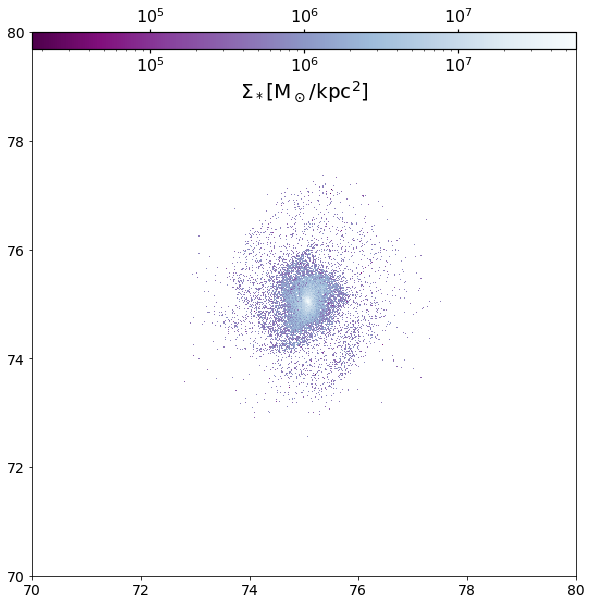

In [10]:
# Plot a map of the stars
g2Msun = 1. / 1.989e33
star_mass_Msun = star_mass*g2Msun
print ("The total stellar mass is {:.2E} Msun".format(sum(star_mass_Msun)))

maps.starmap(star_x, star_y, star_z, star_mass, info, center_plot, rad_plot, \
             var1='x', var2='y', bins=500, rad_circle=False, vmin=None, vmax=None)

#### Cell properties
It is possible to plot a projection, a slice (which can be shifted with _slice_shift) or a column density.

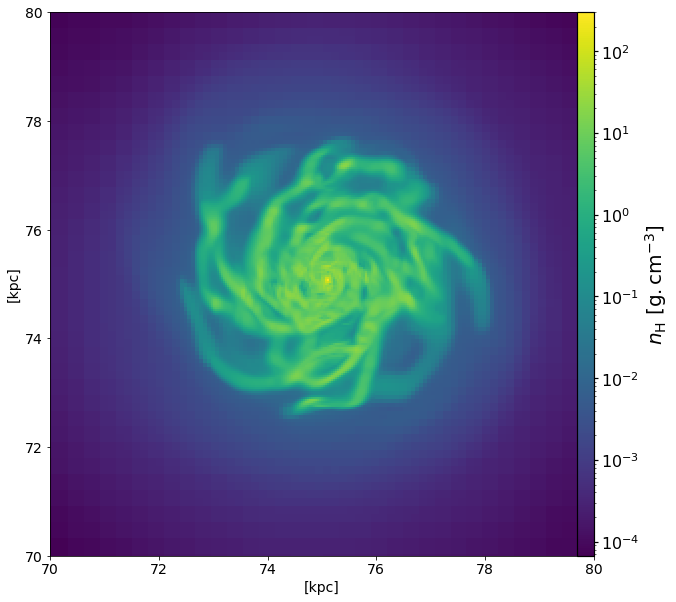

In [11]:
# Projection of the density
maps.qtymap(nH, rho, cell_l, cell_pos, info, center_plot, rad_plot, \
            style='proj', proj='z', vmin=None, vmax=None, mapof='rho', \
            remove_ticks=False, logscale=True, lmax=None, slice_shift=0)

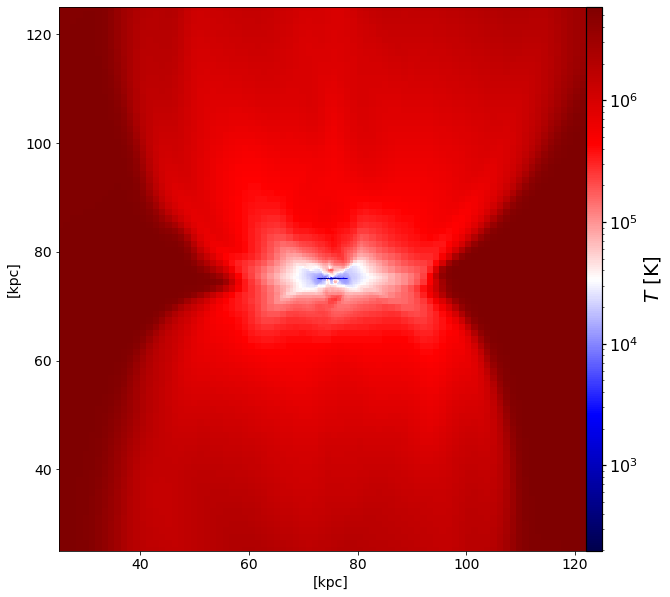

In [12]:
# Slice of the temperature at 0.5 kpc
maps.qtymap(T, rho, cell_l, cell_pos, info, center_plot, rad_plot*10, 
            style='proj', proj='y', vmin=None, vmax=None, mapof='T', 
            remove_ticks=False, logscale=True, lmax=None, slice_shift=0.5)

#### Vertical speed
Note that _vertical_ does not mean much more in cosmological simulations, this was only used on an isolated galaxy.

/home/max/PhD/ratatouille/maps.py:335: UserWarning: Using a weight is totally useless for a slice...
  warnings.warn("Using a weight is totally useless for a slice...")


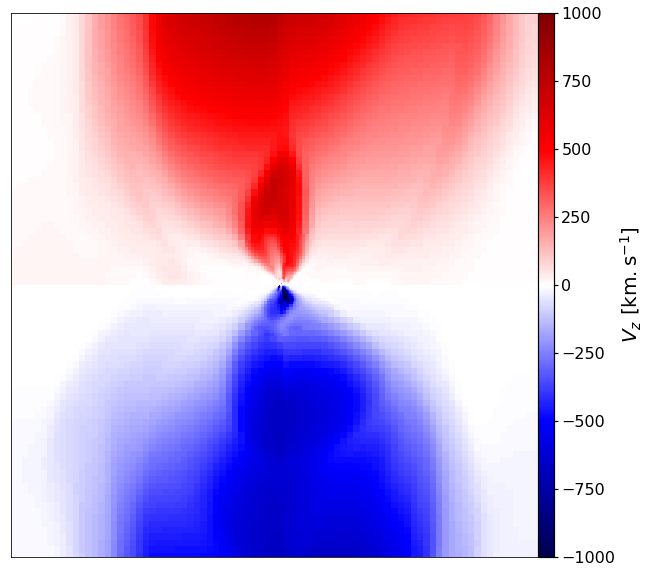

In [13]:
maps.qtymap(vz, nH, cell_l, cell_pos, info, center_plot, rad_plot*10, 
            style='slice', proj='y', vmin=-1000, vmax=1000, mapof='vz_out', 
            remove_ticks=True, logscale=False, lmax=None, slice_shift=0)

#### Levelmap

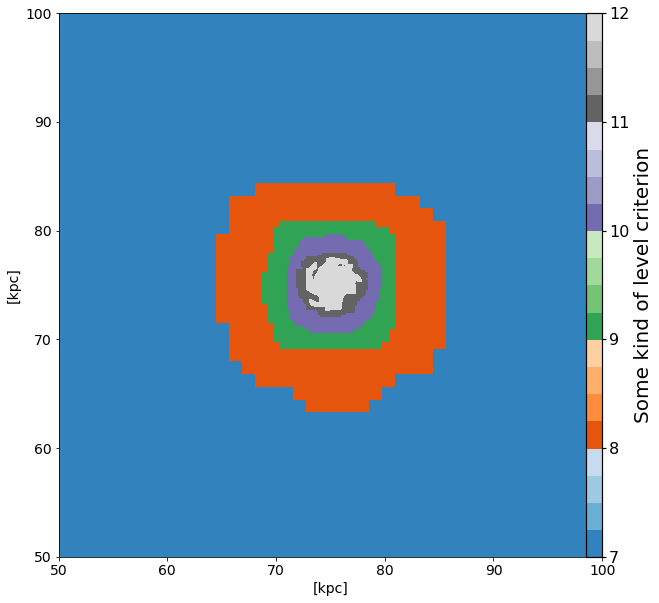

In [14]:
maps.levelmap(cell_l, cell_pos, info, center_plot, rad_plot*5, in_pc=False, \
                style='proj', proj='z', vmin=None, vmax=None, remove_ticks=False, slice_shift=0)

#### Dark matter map

In [ ]:
ms.plot_halos_dm_map(RamsesDir,timestep,MyHalos=[],show_halonumber=True,figname=None)

---

# 3 - k-d tree
Or how to link stars to their host cells.

#### Commands

In [15]:
# To restrict cells quantities to just those containing stars, use array[idx_ccell] as shown.
_,idx_ccell = put.link_stars_cells(cell_pos,cell_l,star_x,star_y,star_z)

In [16]:
# To restrict cells quantities to those whose stars went supernova recently, use array[idx_r].
# This criterion is quite useless but can be used as a reference for any other restriction.
low_lim        = 10 # [Myrs]
idx_SN_massage = put.sel_SN_massage(low_lim, star_age, star_minit, star_mass)
idx_r          = idx_ccell[idx_SN_massage]

#### Example

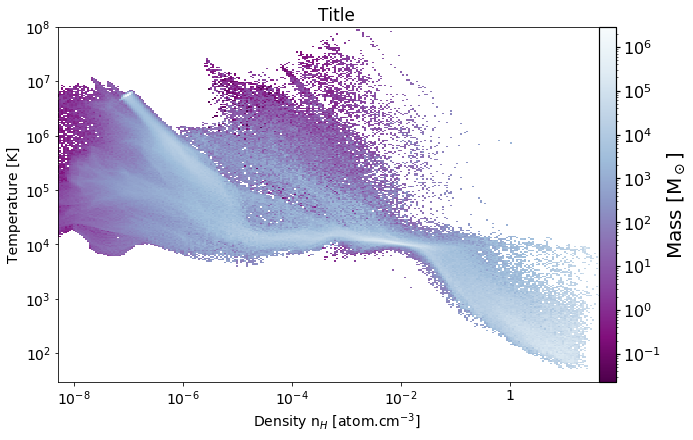

In [17]:
# A normal phase diagram
pltlim = [[5e-9,9e1],[3e1,1e8]]
put.plot_phase_diag(RamsesDir, [""], timestep, labels, bins=300, plot_lims=pltlim, \
                     vmin=None, vmax=None, factor=1, saveinfile=True, savefig=False)

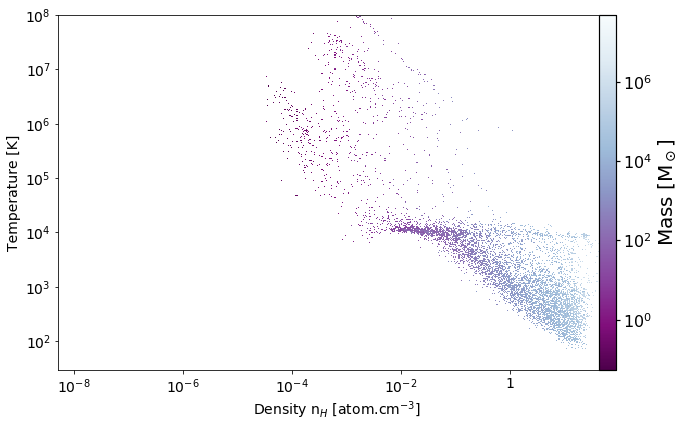

In [18]:
# Now, only the environment of the stellar particles
nH_s = (nH[idx_ccell], 'Density n$_H$ [atom.cm$^{-3}$]')
T_s = (T[idx_ccell], 'Temperature [K]')
mass_s = (mass[idx_ccell], 'Mass [M$_\odot$]')
put.plot_phase_diag(nH_s, T_s, mass_s, bins=350, plot_lims=pltlim)

/home/max/.soft/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


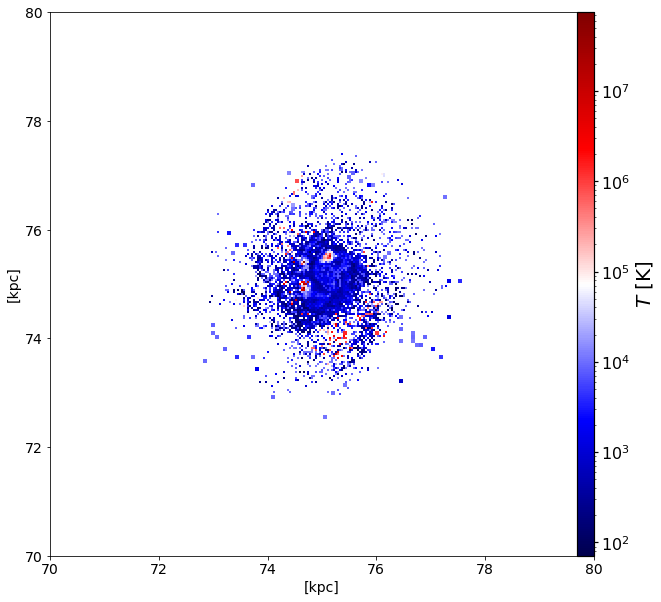

In [19]:
# The same can be done with the maps presnted previously.
maps.qtymap(T[idx_ccell], rho[idx_ccell], cell_l[idx_ccell], cell_pos[idx_ccell], info, \
            center_plot, rad_plot, style='proj', proj='z', mapof='T', remove_ticks=False)